# Práctica Guiada: Maldición de la Dimensionalidad

In [1]:
%pylab inline
import seaborn as sns
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Proporción de outliers

Si tenemos una variable distribuida uniformemente en un hipercubo de $d$ dimensiones, ¿qué propoción de outliers encontramos? 

Podemos definir outliers como aquellos puntos que toman valores extremos en alguna de las $d$ dimensiones. 

Por ejemplo, si pensamos en dos dimensiones, se nos forma un cuadrado.

**Nota:** Este código sirve para generar un dataset artificial. No es fundamental entenderlo en profundidad.

Outliers  18 de 500


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


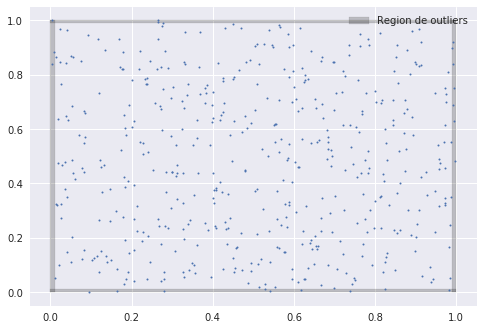

In [2]:
m = 500
xs = uniform(0.0,1.0,m)
ys = uniform(0.0,1.0,m)
X = c_[xs,ys]
plot(xs,ys,'o',ms=2);
x = [0.0,1.0]
p = 0.01 # 1%
fill_between(x,0,p,alpha=0.2,color='k')
fill_between(x,1-p,1,alpha=0.2,color='k')
fill_betweenx(x,0,p,alpha=0.2,color='k')
fill_betweenx(x,1-p,1,alpha=0.2,color='k',label='Region de outliers');
legend();
print('Outliers ',sum([any([(d < .01 or d > .99) for d in p]) for p in X]),'de',m)

Ahora bien, ¿qué pasa a medida que aumentamos la dimensionalidad del dataset? Dado que no podemos graficar en más de tres dimensiones, lo que haremos será graficar la evolución de la proporción de outliers para cada nivel de dimensionalidad.

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


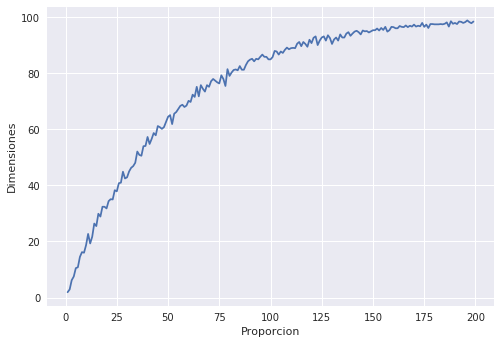

In [3]:
def sample_(d, N=1000):
    '''Genera una muestra de 1000 puntos en d dimensiones'''
    return [[uniform(0., 1.) for i in range(d)] for _ in range(N)]

def corner_count(points):
    '''Cuenta la cantidad de puntos que son outliers en alguna de las d dimensiones.'''
    return mean([any([(d < .01 or d > .99) for d in p]) for p in points])

Ds=arange(1,200)
plot(Ds, array([corner_count(sample_(d)) for d in Ds])*100);
xlabel('Proporcion')
ylabel('Dimensiones');

* ¿Qué observan?
* ¿Qué sucede con la proporción de outliers a medida que el espacio de predictores se incrementa en dimensionalidad?
* ¿Por qué puede deberse esto?

## Retomemos el ejemplo de regresion logística

A continuación vamos a ver qué sucede con la performance de una regresión logística sin regularización a medida que aumenta la cantidad de dimensiones.

La regresión deberá predecir datos simulados a través de distribuciones normales multivariadas.

* La clase 0 tendrá media 0 y las varianzas de todas las dimensiones valdrán 0.5
* La clase 1 tendrá media 1 y las varianzas de todas las dimensiones valdrán 0.5

### Regresión logística sobre datos de distintas dimensiones

Generamos una lista de posibles dimensiones y para cada uno de estos valores generamos un dataset simulado con las características descriptas arriba.

Sobre estos datos corremos y evaluamos una regresión logística para cada dimensionalidad. La métrica de evaluación será el promedio del score de test, utilizando cross validation con una partición de 5 folds en todos los casos. 

In [4]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model  import LogisticRegression
score = []
# Evaluamos el modelo en todas estas dimensiones
ds = [1,3,6,40,50,60,120,180]

for d in ds:

    size0 = 40; size1 = 40;
    
    loc0 = ones(d); loc1 = zeros(d)
    
    sigma0 = 0.5; sigma1 = 0.5; C0 = sigma0*diag(ones(d)); C1 = sigma1*diag(ones(d))

    #Generamos datos multivariados
    x = c_[multivariate_normal(loc0,C0,size0),zeros(size0)]
    y = c_[multivariate_normal(loc1,C1,size1),ones(size1)]
    X = r_[x,y]

    #Creamos la matriz de features
    dfX = pd.DataFrame(X)
    dfX.columns = ['dim'+str(i) for i in range(d)]+['class']
    X = dfX.drop('class',axis=1)
    y = dfX['class']
    
    # Guardamos la media del score de cross-validation
    model = LogisticRegression(C = 1e10,n_jobs=4)
    kf = KFold(5, shuffle=True, random_state=0)
    score.append(np.mean(cross_val_score(model,X,y,cv=kf)))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228

Observamos que a partir de cierta cantidad de dimensiones, la performance empieza a caer fuertemente debido al exceso de dimensiones en relación a la cantidad de datos disponibles

In [5]:
score

[0.77500000000000002,
 0.88749999999999996,
 0.88749999999999996,
 0.97499999999999998,
 0.97499999999999998,
 0.94999999999999996,
 0.97499999999999998,
 0.83750000000000002]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


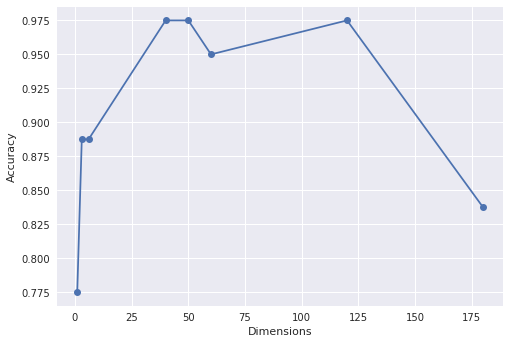

In [6]:
plt.plot(ds,score,'o-');
ylabel('Accuracy')
xlabel('Dimensions');

Si el volumen de datos aumenta, la cantidad óptima de dimensiones también aumenta. 

In [7]:
score = []
# Evaluamos el modelo en todas estas dimensiones
ds = [1,3,6,40,50,60,120,180]

for d  in ds:

    size0 = 4000; size1 = 4000;
    
    loc0 = ones(d); loc1 = zeros(d)
    
    sigma0 = 0.5; sigma1 = 0.5; C0 = sigma0*diag(ones(d)); C1 = sigma1*diag(ones(d))

    #Generamos datos multivariados
    x = c_[multivariate_normal(loc0,C0,size0),zeros(size0)]
    y = c_[multivariate_normal(loc1,C1,size1),ones(size1)]
    X = r_[x,y]

    #Creamos la matriz de features
    dfX = pd.DataFrame(X)
    dfX.columns = ['dim'+str(i) for i in range(d)]+['class']
    X = dfX.drop('class',axis=1)
    y = dfX['class']
    
    # Guardamos la media del score de cross-validation
    model = LogisticRegression(C = 1e10,n_jobs=4)
    kf = KFold(5, shuffle=True, random_state=0)
    score.append(np.mean(cross_val_score(model,X,y,cv=kf)))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


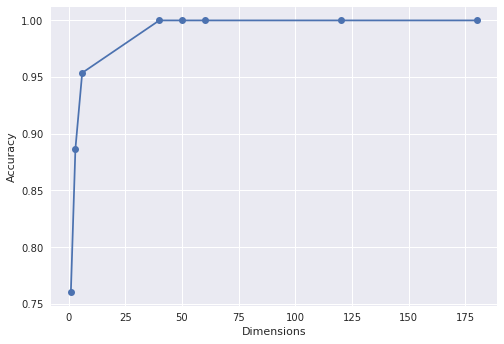

In [8]:
plt.plot(ds,score,'o-');
ylabel('Accuracy')
xlabel('Dimensions');